#N2 Method

This simplified nonlinear procedure for the estimation of the seismic response of structures uses capacity curves and inelastic spectra. This method has been developed to be combined with code-bsed response spectra, but is is also possible to employ it to assess structural response against ground motion records. It also has the distinct aspect of assuming an elasto-perfectly plastic force-displacement relationship in the construction of the bilinear curve.

In the following figure, a fragility model developed using this method is presented: 
<img src="../../../../../figures/fragility_example.png" height="200" width="400" align="middle">

##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of the folder containing this input using the parameter input_folder.

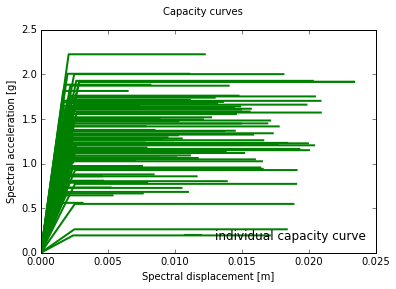

In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../../../Google Drive 2/Otros GEM/SARA/03_RMTKInput/MUR_H1.csv'
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)

## Load ground motion records

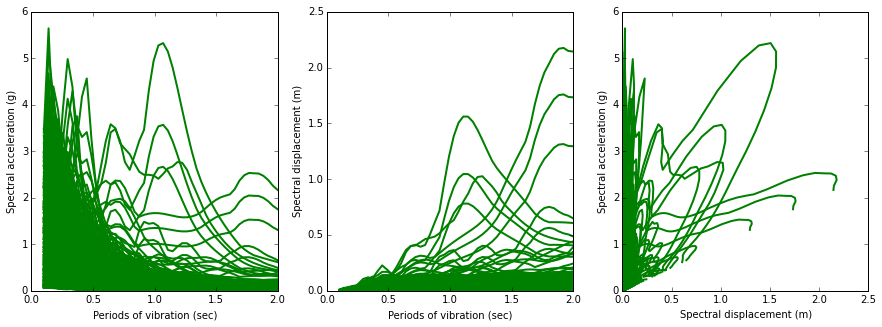

In [2]:
gmrs_folder = '../../../../../../../Google Drive 2/Otros GEM/SARA/04_Records/PGA/All_records'
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.1
maxT = 2
utils.plot_response_spectra(gmrs,minT,maxT)

##Calculate fragility function


In [3]:
import N2Method

damage_model = utils.read_damage_model('../../../../../../rmtk_data/damage_model.csv')
print damage_model
damping = 0.05
T = 0.001
PDM, Sds = N2Method.calculate_fragility(capacity_curves,gmrs,damage_model,damping)
fragility_model = utils.calculate_mean_fragility(gmrs,PDM,T,damping,'Sa',damage_model)
utils.plot_fragility_model(fragility_model,0.01,2)

{'damage_states': ['Slight', 'Moderate', 'Extensive', 'Collapse'], 'cov': [0.0, 0.0, 0.0, 0.0], 'type_criteria': 'capacity curve dependent', 'type_damage_state': ['Sdy', '3 Sdy 1 Sdu', '1 Sdy 1 Sdu', 'Sdu'], 'distribution': ['normal', 'normal', 'normal', 'normal'], 'mean': ['0.0', '0.0', '0.0', '0.0']}
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
100%


TypeError: plot_fragility_model() takes exactly 4 arguments (3 given)

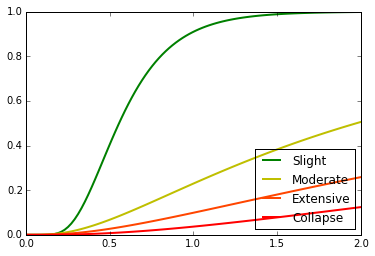

In [5]:
save=True
utils.plot_fragility_model(fragility_model,0.01,2,save)
utils.create_fragility_out_files(fragility_model,'median-dispersion',save)